In [3]:
%%bash
pip install smbprotocol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 25.0 MB/s eta 0:00:00


In [4]:
# Imports
import numpy as np
import pandas as pd
import smbclient
import os
import tempfile

In [5]:
import os
os.environ['SMB_SERVER_IP'] = '192.168.0.159'
os.environ['SMB_SERVER_PORT'] = '445'
os.environ['SMB_USERNAME'] = 'matin'
os.environ['SMB_PASSWORD'] = 'greenbird'
os.environ['SMB_SHARE_NAME'] = 'sambashare'

In [6]:
smb_server_ip = os.environ['SMB_SERVER_IP']
smb_server_port = int(os.environ['SMB_SERVER_PORT'])
smb_username = os.environ['SMB_USERNAME']
smb_password = os.environ['SMB_PASSWORD']
smb_share_name = os.environ['SMB_SHARE_NAME']

remote_term_df_path = 'apple_term_df_compressed.csv.gz'
remote_bigram_df_path = 'apple_bigram_df_compressed.csv.gz'

# Set the SMB client configuration with the provided credentials
smbclient.ClientConfig(username=smb_username, password=smb_password)

def download_dataframe_from_smb_server(remote_file_path):
    # Create the full remote path
    remote_path = f"\\\\{smb_server_ip}\\{smb_share_name}\\{remote_file_path}"

    # Download the compressed CSV file from the SMB share
    with tempfile.NamedTemporaryFile(mode='w+b', suffix='.csv.gz', delete=False) as temp_file:
        with smbclient.open_file(remote_path, mode='rb') as remote_file:
            temp_file.write(remote_file.read())
        temp_file_path = temp_file.name

    # Load the temporary compressed CSV file into a pandas DataFrame
    df = pd.read_csv(temp_file_path, compression='gzip')

    # Delete the temporary file
    os.unlink(temp_file_path)

    return df

# Download both DataFrames from the SMB server
term_df = download_dataframe_from_smb_server(remote_term_df_path)
bigram_df = download_dataframe_from_smb_server(remote_bigram_df_path)

In [7]:
term_df.head()

,aal,aap,aapl,aaplo,abandon,abc,abil,abl,abroad,absolut,...,yorkbas,young,youtub,yy,zack,zackscom,zero,zone,zuckerberg,direction
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
bigram_df.head()

,aap team,aapl amazon,aapl appl,aapl base,aapl facebook,aapl free,aapl iphon,aapl microsoft,aapl open,aapl post,...,yield appl,yield benchmark,yield rise,yield year,zack consensu,zack invest,zack rank,zack research,zack stock,direction
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

def plot_explained_variance(dataframes, titles, n_components=100):
    plt.figure(figsize=(10, 6))
    
    for df, title in zip(dataframes, titles):
        # Exclude the last column (label) from the DataFrame
        df_without_label = df.iloc[:, :-1]

        svd = TruncatedSVD(n_components=n_components)
        svd.fit(df_without_label)

        explained_variance = np.cumsum(svd.explained_variance_ratio_)

        plt.plot(range(1, n_components + 1), explained_variance, label=title)
    
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

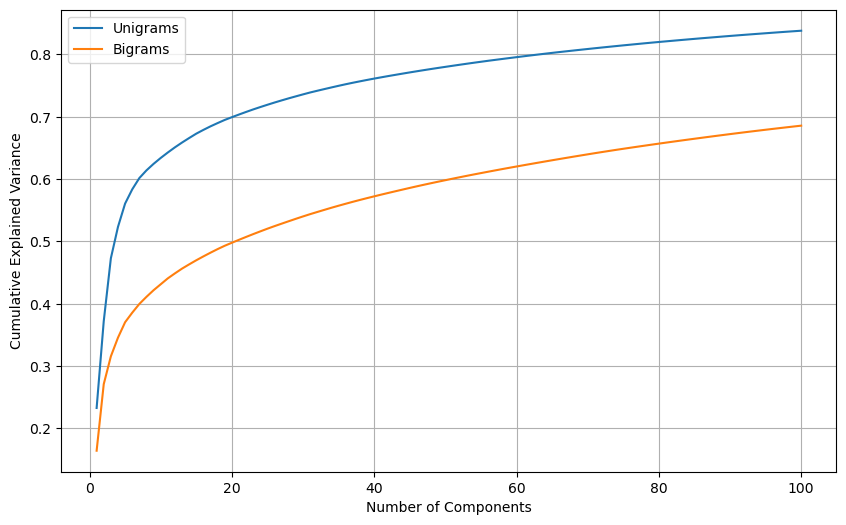

In [10]:
plot_explained_variance([term_df, bigram_df], ['Unigrams', 'Bigrams'])

In [13]:
svd_term = TruncatedSVD(n_components=20, random_state=42)
reduced_term_df = svd_term.fit_transform(term_df)

reduced_term_df = pd.DataFrame(reduced_term_df)
reduced_term_df['label'] = term_df['direction']
reduced_term_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,6.659850,-8.719640,2.055429,5.893679,10.110861,1.323362,5.149128,-6.199346,-7.404197,1.113104,...,3.586231,-1.814502,0.585127,4.193016,2.094102,-2.467977,-0.971604,-1.954872,8.038027,1
1,4.357488,-9.305822,-1.081855,10.967196,-11.215560,4.292394,-6.267285,2.416963,-5.145148,-2.021322,...,0.701190,-4.077391,1.512268,-3.328247,1.484974,-2.066616,-1.255639,0.549822,-0.882772,0
2,1.219548,-1.814727,-0.280696,1.751863,1.606562,-1.084125,1.783763,1.709744,-0.451885,-0.541524,...,-0.015589,0.550292,-0.307176,-0.845645,-1.561775,-1.099621,0.664529,0.268798,0.753169,1
3,5.495706,-8.027836,0.909743,6.890150,7.461051,-4.055750,2.348643,4.183162,1.725309,-7.245438,...,-3.542952,-7.275057,1.742444,7.387549,7.849624,6.635261,-4.304861,3.931171,5.409535,1
4,19.963664,-36.120347,-3.186957,2.684817,-18.021780,1.081048,4.558870,0.731301,3.277737,-3.463588,...,3.901116,-1.361302,0.426343,0.321628,1.965885,-0.606415,-0.375415,1.504731,-0.474068,1


In [14]:
svd_bigram = TruncatedSVD(n_components=60, random_state=42)
reduced_bigram_df = svd_bigram.fit_transform(bigram_df)

reduced_bigram_df = pd.DataFrame(reduced_bigram_df)
reduced_bigram_df['label'] = bigram_df['direction']
reduced_bigram_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,label
0,0.526680,0.339843,0.037858,-0.614661,0.642681,1.715804,2.798251,-0.184123,-1.567530,-1.080481,...,0.198298,-0.293503,-1.778270,0.491013,0.886719,0.281999,1.218237,-0.695535,-1.103370,1
1,0.118962,-0.077396,0.001024,-0.041342,0.001946,0.536339,-0.007341,0.090211,-0.012521,-0.004639,...,-0.105461,0.009304,-0.013621,0.607839,-0.830003,0.249614,0.060548,0.460879,-0.742855,0
2,0.050994,0.029138,0.006711,0.016267,0.028477,0.286243,0.211176,-0.071644,-0.095886,-0.012236,...,-0.222578,-0.103534,-0.122936,0.170850,0.022423,0.089171,0.046482,-0.090478,-0.016856,1
3,0.220387,0.011531,0.006714,0.030028,-0.000063,0.548997,0.340905,-0.284332,-0.121704,0.184894,...,0.150093,0.172957,-0.189973,-0.106555,0.272677,0.017068,0.415295,0.107875,-0.207154,1
4,15.331030,-6.081068,0.245200,-0.773392,1.955606,-0.068759,0.671446,-0.794502,0.158998,3.692566,...,0.257601,-0.354907,0.165867,0.223515,0.127977,0.702849,0.243020,0.146140,-2.345184,1


In [15]:
def save_dataframe_to_smb_server(df, remote_file_path):
    # Create a temporary file to store the compressed CSV
    with tempfile.NamedTemporaryFile(mode='w+', suffix='.csv.gz', delete=False) as temp_file:
        df.to_csv(temp_file.name, index=False, compression='gzip')
        temp_file_path = temp_file.name

    # Create the full remote path
    remote_path = f"\\\\{smb_server_ip}\\{smb_share_name}\\{remote_file_path}"

    # Upload the temporary compressed CSV file to the SMB share
    with open(temp_file_path, 'rb') as local_file:
        with smbclient.open_file(remote_path, mode='wb') as remote_file:
            remote_file.write(local_file.read())

    # Delete the temporary file
    os.unlink(temp_file_path)

# Save both DataFrames to the SMB server
save_dataframe_to_smb_server(reduced_term_df, 'apple_term_df_reduced_compressed.csv.gz')
save_dataframe_to_smb_server(reduced_bigram_df, 'apple_bigram_df_reduced_compressed.csv.gz')